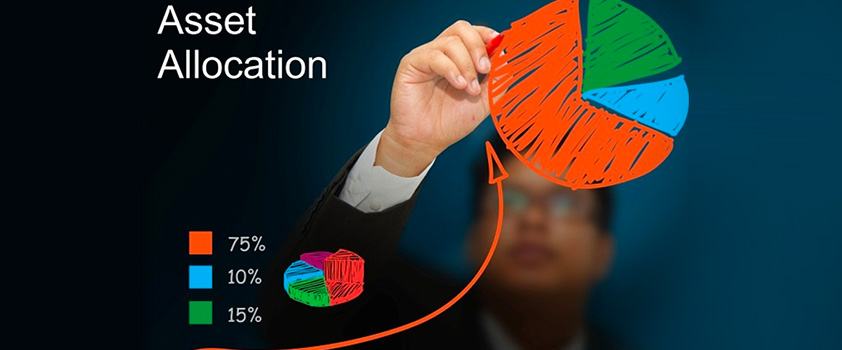

In [103]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import numpy as np
import matplotlib.ticker as mtick
import scipy as sco
import math

In [104]:
# Definindo os símbolos dos índice IBOV e ETF IVVB11 (S&P[IVV] + DÓLAR)
ibov_symbol = '^BVSP'  # Índice IBOV
ivvb11_symbol = 'IVVB11.SA'  # ETF do S&P 500 na B3 (Bolsa de Valores do Brasil) - Início limitado (maio/2016)

# Definindo a data inicial e final para as cotações históricas do estudo
start_date = '2013-01-01'
end_date = '2023-10-26'

# Baixando os dados históricos usando yfinance
ibov_data = yf.download(ibov_symbol, start=start_date, end=end_date)
ivvb11_data = yf.download(ivvb11_symbol, start=start_date, end=end_date)

# Baixando dados IFIX (está em planilha Excel, usei GOOGLEFINANCE & Google Sheets). YFinance está sem os dados.
ifix_data = pd.read_excel('Historico IFIX 01-01-2013 ate 20-10-2023.xlsx')

# Filtrando os registros com datas a partir de start_date, para igualar o período dos outros índices (Início IFIX set/2012)
ifix_data = ifix_data[ifix_data['Date'] >= start_date]
# Fazendo também com o end_date
ifix_data = ifix_data[ifix_data['Date'] <= end_date]

# Padronizando as datas no DataFrame ifix_data para 00:00:00 (elas vem com horário de encerramento [~16h56] e causa problemas)
ifix_data['Date'] = ifix_data['Date'].dt.floor('D')

# Definindo a coluna "Date" da planilha como o índice do DataFrame
ifix_data = ifix_data.set_index('Date')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [105]:
# Consultando o Dados Abertos do BC para ter a Taxa Selic anualizada - Renda Fixa (CDI)

# Função de Busca dos Dados - Irei buscar a taxa Selic diaria (mais facil para aplicar a um investimento e comparar com os indices)

def CarregaDadosSelic(data_inicial, data_final):
    # Carrega um intervalo de taxas Selic no período data inicial até data final
    url_bcb = f'https://api.bcb.gov.br/dados/serie/bcdata.sgs.11/dados?formato=json&dataInicial={data_inicial}&dataFinal={data_final}'
    
    selic_historica = pd.read_json(url_bcb)
    return selic_historica

# Execução

# Convertendo a data do formato americano (yahoofinance) de str para objeto data
start_date_dttime = datetime.strptime(start_date, '%Y-%m-%d')
end_date_dttime = datetime.strptime(end_date, '%Y-%m-%d')
# Formatando a data no novo padrão 'DD/MM/YYYY'
start_date_br = start_date_dttime.strftime('%d/%m/%Y')
end_date_br = end_date_dttime.strftime('%d/%m/%Y')

# Carregando e jogando em um DataFrame
selic_data = CarregaDadosSelic(start_date_br, end_date_br)
selic_data.rename(columns={'data': 'Date', 'valor': 'Close'}, inplace=True)

# Definindo a data como um índice e também no formato 'YYYY-MM-DD', do mesmos outros dfs
selic_data = selic_data.set_index('Date')
selic_data.index = pd.to_datetime(selic_data.index, format='%d/%m/%Y')

# Certo. Agora tenho o gráfico da Selic histórica média últimos 12 meses (252 dias úteis). Mas quero ver a linha de investimento
# de estar 100% CDI, ou seja, replicando essa taxa Selic over.

# OBSERVAÇÃO IMPORTANTE: Esta será também a taxa livre de risco (RF rate) para cálculo de índice Sharpe

# Também vou começar de base 100, como os outros índices
valor_inicial = 100
selic_data['Close Adj'] = 0
selic_data.loc[selic_data.index[0], 'Close Adj'] = valor_inicial

# Simulando o investimento 100% na Taxa Selic
for i in range(1, len(selic_data)):
    # Calculando o valor do investimento dia a dia com base na taxa SELIC
    selic_data.loc[selic_data.index[i], 'Close Adj'] = selic_data.loc[selic_data.index[i - 1], 'Close Adj'] * (1 + selic_data['Close'][i] / 100)


In [106]:
# Capturando o "Real IVVB11", que seria a variação do S&P500 + a variação do Dólar/BRL. Isso porque a data do histórico de
# criação do ETF está limitando a janela de análise (maio/2016)

# Definindo os símbolos da cotação Dólar/Real e S&P 500
dollar_symbol = 'BRL=X'  # Símbolo do dólar
sp500_symbol = 'IVV'     # Símbolo do S&P 500 (IVV)

# Baixando os dados
dollar_data = yf.download(dollar_symbol, start=start_date, end=end_date)
sp500_data = yf.download(sp500_symbol, start=start_date, end=end_date)

# Unindo os DataFrames usando a data e hora como índice
dollar_ivv = pd.concat([dollar_data['Close'], sp500_data['Close']], axis=1)
dollar_ivv.columns = ['Dollar', 'SP500']
dollar_ivv = dollar_ivv.drop(dollar_ivv.index[0])

# Calculando a variação percentual intraday para ambos os ativos
dollar_ivv['Dollar_Return'] = dollar_ivv['Dollar'].pct_change()
dollar_ivv['SP500_Return'] = dollar_ivv['SP500'].pct_change()

# Somando as duas variações percentuais (S&P 500 e USD/BRL) para criar o índice desejado
dollar_ivv['IVV'] = dollar_ivv['Dollar_Return'] + dollar_ivv['SP500_Return']
# Ajustando o valor da primeira linha para 0 (sem variação)
dollar_ivv['IVV'].iloc[0] = 0

# Passando o índice criado (S&P+Dólar) para base 100 a partir da segunda linha
dollar_ivv['IVV Adj'] = (1 + dollar_ivv['IVV']).cumprod() * 100


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


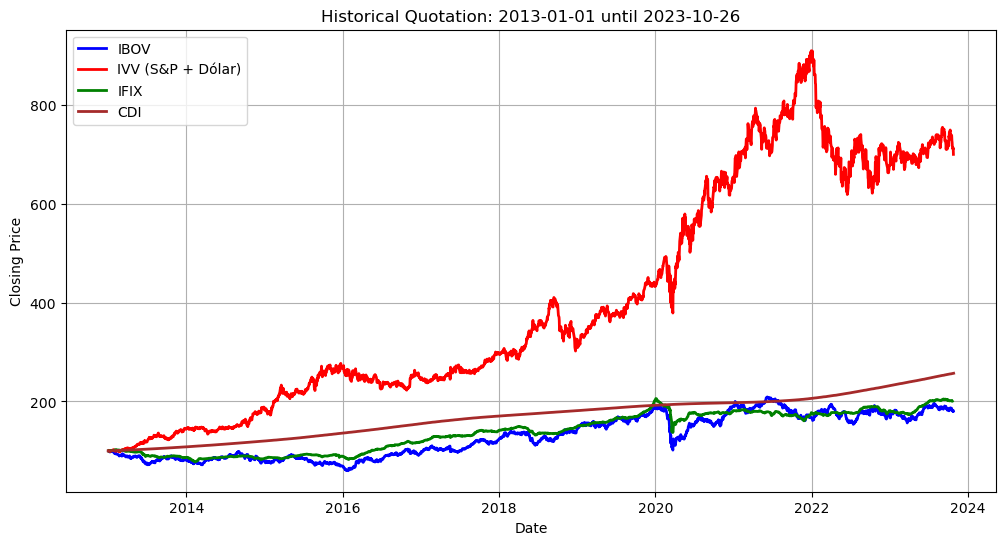

In [107]:
# Valor base comum entre os índices (para que comecem no mesmo ponto no gráfico)
valor_base = 100

# Normalizando os DataFrames dividindo pela base comum
ibov_data['Close'] = ibov_data['Close'] / ibov_data['Close'].iloc[0] * valor_base
ifix_data['Close'] = ifix_data['Close'] / ifix_data['Close'].iloc[0] * valor_base

# Criando o gráfico
plt.figure(figsize=(12, 6))

plt.plot(ibov_data.index, ibov_data['Close'], label='IBOV', color='blue', linewidth=2)
plt.plot(dollar_ivv.index, dollar_ivv['IVV Adj'], label='IVV (S&P + Dólar)', color='red', linewidth=2)
plt.plot(ifix_data.index, ifix_data['Close'], label='IFIX', color='green', linewidth=2)
plt.plot(selic_data.index, selic_data['Close Adj'], label='CDI', color='brown', linewidth=2)

plt.title(f'Historical Quotation: {start_date} until {end_date}')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)

# Exiba o gráfico no Jupyter Notebook
plt.show()

In [108]:
# Fazendo o cálculo de média-variância (para modelo MVO), retornos esperados e volatilidade (desvio) esperada, baseada 
# no histórico. Executando múltiplas janelas para redução do viés de enquadramento

janelas_tempo = [252, 252 * 3, 252 * 5, 252 * 10]  # 252 dias úteis = 1 ano (pregões). 1 ano, 3 anos, 5 anos, 10 anos.
nome_janelas = ['1 ano', '3 anos', '5 anos', '10 anos']

# Renomeando coluna para poder colocar todos os retornos em um único df
ifix_data.rename(columns={'Close': 'Close IFIX'}, inplace=True)

# DF com a variação de todos os índices
all_classes_return = pd.concat([ibov_data['Close'], dollar_ivv['IVV Adj'], selic_data['Close Adj'], 
                                ifix_data['Close IFIX']], axis=1)
# Renomeando as colunas
all_classes_return.rename(columns={'Close': 'IBOV', 'IVV Adj': 'IVV', 'Close Adj': 'CDI', 'Close IFIX': 'IFIX'}, inplace=True)
# Preenchendo os valores ausentes (NaN) usando interpolação linear
all_classes_return = all_classes_return.interpolate(method='linear')

# Criando um DataFrame para armazenar os resultados das janelas de tempo
windows_results = pd.DataFrame(index=all_classes_return.index)

# Iterando pelas janelas de tempo
for janela, nome in zip(janelas_tempo, nome_janelas):
    nome_coluna = f'Retorno_{nome}'
    retorno_janela = all_classes_return.pct_change().rolling(window=janela).apply(lambda x: np.prod(1 + x) - 1)
    taxa_retorno_anualizado = (1 + retorno_janela) ** (252 / janela) - 1
    for coluna in taxa_retorno_anualizado.columns:
        windows_results[f'{coluna}_{nome_coluna}'] = taxa_retorno_anualizado[coluna]

# windows_results.tail()

In [109]:
# Criando DataFrames com as métricas de: Média de Retorno (das múltiplas janelas) e Desvio-Padrão dos retornos (risco/volatilidade)

# Lista que armazenará os dfs
lista_dfs_retornos = []

# Loop para criar os DataFrames de média e desvio-padrão
for janela in nome_janelas:
    columns = [f'{indice}_Retorno_{janela}' for indice in ['IBOV', 'IVV', 'CDI', 'IFIX']]
    df_janelas = windows_results[columns]
    
    # Média de Retornos na Janela
    avg_return = df_janelas.mean()
    # Desvio-Padrão dos Retornos na Janela
    sd_return = df_janelas.std()
    # Retorno do CDI na Janela (Taxa Livre de Risco)
    risk_free_rate = df_janelas.iloc[:,2].mean()
    # Sharpe Ratio
    sharpe_ratio = (avg_return - risk_free_rate) / sd_return
    
    df_estatisticas = pd.DataFrame({
        'Média': avg_return * 100,
        'Desvio-Padrão': sd_return * 100,
        'Risk-Free': risk_free_rate * 100,
        'Sharpe': sharpe_ratio
    })

    lista_dfs_retornos.append(df_estatisticas)
    
lista_dfs_retornos

[                        Média  Desvio-Padrão  Risk-Free    Sharpe
 IBOV_Retorno_1 ano   8.910040      18.229586   8.730286  0.009861
 IVV_Retorno_1 ano   21.184891      21.628663   8.730286  0.575838
 CDI_Retorno_1 ano    8.730286       3.673602   8.730286  0.000000
 IFIX_Retorno_1 ano   7.765183      12.365268   8.730286 -0.078050,
                          Média  Desvio-Padrão  Risk-Free    Sharpe
 IBOV_Retorno_3 anos  10.205906       8.690521   8.279311  0.221689
 IVV_Retorno_3 anos   20.786518       8.579615   8.279311  1.457782
 CDI_Retorno_3 anos    8.279311       2.991855   8.279311  0.000000
 IFIX_Retorno_3 anos   9.154045       6.492736   8.279311  0.134725,
                          Média  Desvio-Padrão  Risk-Free    Sharpe
 IBOV_Retorno_5 anos  11.603927       4.591133   8.089951  0.765383
 IVV_Retorno_5 anos   20.514613       3.845387   8.089951  3.231056
 CDI_Retorno_5 anos    8.089951       2.053090   8.089951  0.000000
 IFIX_Retorno_5 anos   9.961927       3.770892   8.

In [110]:
# Calculando os parâmetros diários de Média e Variância para Cálculo de Portfólio Ótimo
daily_returns_all_classes = all_classes_return.pct_change().fillna(0)
daily_returns_all_classes_avg = daily_returns_all_classes.mean()*100
daily_returns_all_classes_stddev = daily_returns_all_classes.std()*100

# daily_returns_all_classes

In [111]:
# Calculando retornos, volatilidade e covariancia logarítmicos
daily_returns_all_classes_log = np.log(all_classes_return/all_classes_return.shift(1)).fillna(0)
daily_returns_all_classes_log= daily_returns_all_classes_log.drop('CDI', axis=1) ########### Linha teste
daily_returns_all_classes_log_avg = daily_returns_all_classes_log.mean()
daily_returns_all_classes_log_stddev = daily_returns_all_classes_log.std()
daily_returns_all_classes_log_cov = daily_returns_all_classes_log.cov() # Matriz de Covariância

daily_returns_all_classes_log

,IBOV,IVV,IFIX
Date,,,
2012-12-31,0.000000,0.000000,0.000000
2013-01-02,0.000000,0.000000,0.000000
2013-01-03,0.012109,-0.001297,-0.000481
2013-01-04,-0.012540,0.006412,0.001480
2013-01-07,-0.009481,-0.011144,0.000613
...,...,...,...
2023-10-20,-0.007475,-0.011017,0.001374
2023-10-23,-0.003275,-0.008022,0.000000
2023-10-24,0.008625,0.003745,0.000000


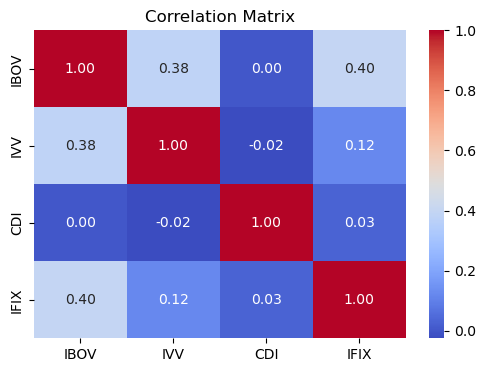

In [112]:
# Matriz de Correlação
correlation_matrix = daily_returns_all_classes.corr()

# Cria um mapa de calor usando o Seaborn
plt.figure(figsize=(6, 4))  # Define o tamanho da figura
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

plt.title('Correlation Matrix')  
plt.show()

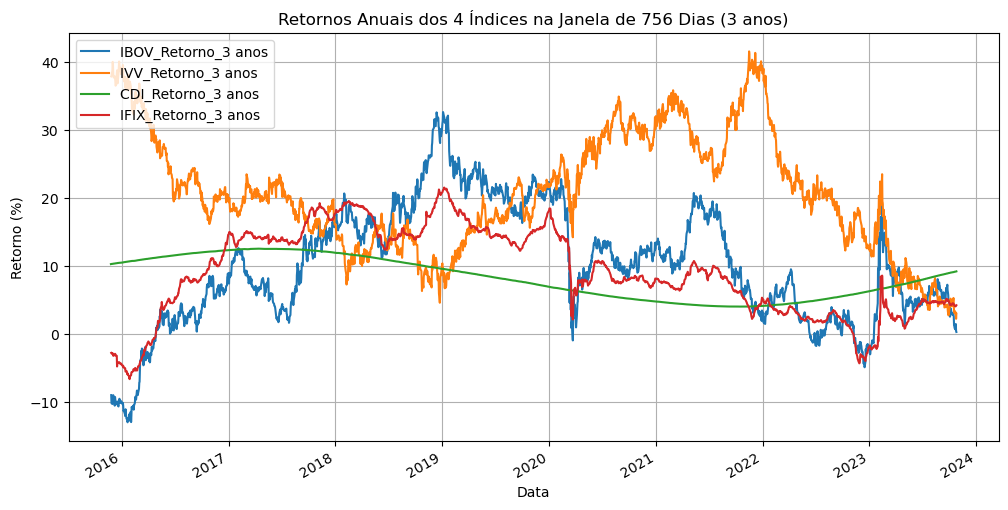

In [113]:
# Gerando grafico para janelas de 3 anos

# Selecionando apenas as colunas de janelas com 3 anos
colunas = ["IBOV_Retorno_3 anos", "IVV_Retorno_3 anos", "CDI_Retorno_3 anos", "IFIX_Retorno_3 anos"]

# Criando um gráfico de linhas para exibir os retornos
windows_results[colunas] = windows_results[colunas] * 100  # Multiplicar por 100 para obter porcentagens
windows_results[colunas].plot(figsize=(12, 6))
plt.title("Retornos Anuais dos 4 Índices na Janela de 756 Dias (3 anos)")
plt.xlabel("Data")
plt.ylabel("Retorno (%)")
plt.grid(True)
plt.legend(loc="upper left")
plt.show()

In [114]:
daily_returns_all_classes_log

,IBOV,IVV,IFIX
Date,,,
2012-12-31,0.000000,0.000000,0.000000
2013-01-02,0.000000,0.000000,0.000000
2013-01-03,0.012109,-0.001297,-0.000481
2013-01-04,-0.012540,0.006412,0.001480
2013-01-07,-0.009481,-0.011144,0.000613
...,...,...,...
2023-10-20,-0.007475,-0.011017,0.001374
2023-10-23,-0.003275,-0.008022,0.000000
2023-10-24,0.008625,0.003745,0.000000


In [115]:
# Geração dos portfolios
n_portfolios = 1000

p_ret=[]
p_vol=[]
p_pesos=[]

n_ativos=len(daily_returns_all_classes_log.columns) # Quantidade de ativos

for portfolios in range(n_portfolios):
    pesos=np.random.random(n_ativos) # Pesos aleatórios
    pesos=pesos/np.sum(pesos) # Pesos que somam 1
    p_pesos.append(pesos)
    
    returns=np.dot(pesos, daily_returns_all_classes_log_avg) # Retornos
    p_ret.append(returns)
    
    var=daily_returns_all_classes_log_cov.mul(pesos, axis=0).mul(pesos, axis=1).sum().sum() # Covariância
    dp=np.sqrt(var) # Desvio-Padrão
    p_vol.append(dp)

p_ret=np.array(p_ret)
p_vol=np.array(p_vol)
dados={'Retorno': p_ret, 'Risco': p_vol}
portfolios=pd.DataFrame(dados)
#portfolios

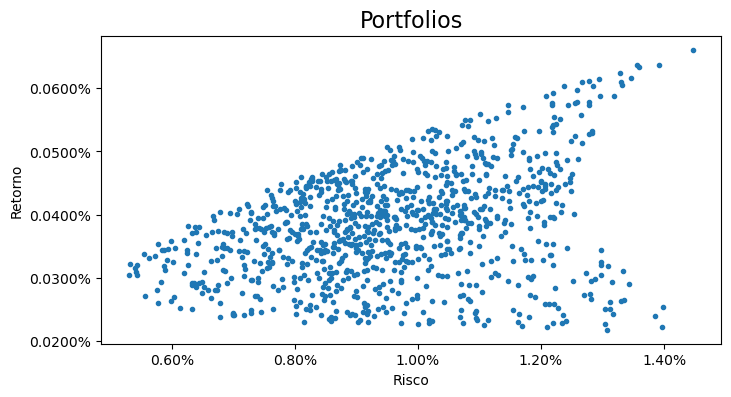

In [116]:
# Gráfico de Portfolios
plt.figure(figsize=(8,4))
plt.scatter(portfolios['Risco'], portfolios['Retorno'], marker='.')
plt.title('Portfolios', fontsize=16)
plt.xlabel('Risco')
plt.ylabel('Retorno')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

In [117]:
# Portfolios com Sharpe
risk_free_tx = daily_returns_all_classes_log_avg[2]
risk_free_tx

0.0002463673200110102

In [118]:
# Carteira de Menor Risco

# Definição das funções para Retorno e Risco

def port_ret(pesos): # Função de cálculo de retorno
    return np.sum(daily_returns_all_classes_log_avg*pesos)

def port_vol(pesos): # Função de cálculo de risco
    return math.sqrt(np.dot(pesos,np.dot(daily_returns_all_classes_log_cov, pesos))) 
    # Lembrar que o np.dot ignora o .T de transposição do vetor. Sempre faz a multiplicação automática

In [153]:
# Definição de restrições da função

tpl1 = 0.00 # Limite mínimo de alocação
tpl2 = 1-tpl1 # Limite máximo de alocação

restri = ({'type': 'eq', 'fun': lambda x: np.sum(x)-1}) # A soma dos pesos é 1
bnds = tuple((tpl1, tpl2) for x in range(n_ativos)) # Gera uma tupla de (tpl1, tpl2) para cada ativo
pesos_i = np.array(n_ativos*[1/n_ativos]) # Inicia com pesos iguais para todos os ativos

In [154]:
# Otimização da Carteira
otim_menor_vol=sco.optimize.minimize(port_vol, pesos_i, method='SLSQP', bounds=bnds, constraints=restri)

# Pesos otimizados com menor risco
peso_otimo = otim_menor_vol['x'].round(2)
ret_otimo = port_ret(otim_menor_vol['x'])
vol_otimo = port_vol(otim_menor_vol['x'])

print('Rótulos: ', daily_returns_all_classes_log.columns.to_list(), '\n',
     'Pesos da carteira de menor risco: ', peso_otimo, '\n',
     'Retorno da carteira de menor risco: ', '{:.2%}'.format(ret_otimo), '\n',
     'Risco da carteira de menor risco: ', '{:.2%}'.format(vol_otimo))


Rótulos:  ['IBOV', 'IVV', 'IFIX'] 
 Pesos da carteira de menor risco:  [0.   0.06 0.94] 
 Retorno da carteira de menor risco:  0.03% 
 Risco da carteira de menor risco:  0.51%


In [155]:
# Estimação da Fronteira Eficiente

cons = ({'type': 'eq', 'fun': lambda x: port_ret(x) - tret}, {'type':'eq', 'fun': lambda x: np.sum(x)-1})
trets = np.linspace(p_ret.min(), p_ret.max(), 50)
tvols=[]

for tret in trets:
    res = sco.optimize.minimize(port_vol, pesos_i, method='SLSQP', bounds=bnds, constraints=cons)
    tvols.append(res['fun'])
    
tvols=np.array(tvols)

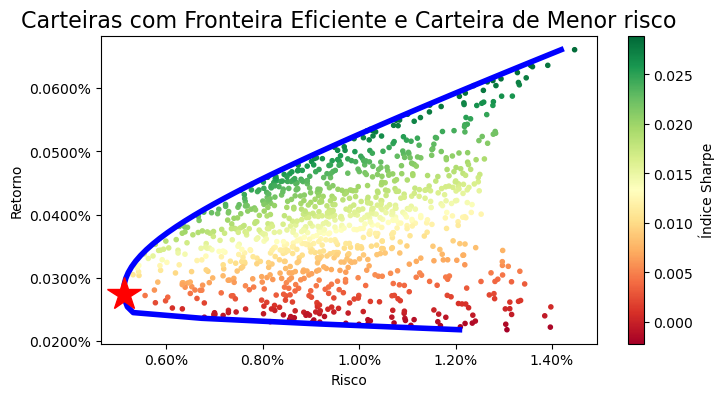

In [156]:
# Gráfico da Fronteira Eficiente com a carteira de menor risco
plt.figure(figsize=(8,4))
plt.scatter(p_vol, p_ret, c=(p_ret-risk_free_tx)/p_vol, marker='.', cmap='RdYlGn')
plt.plot(tvols, trets, 'b', lw=4)
plt.plot(port_vol(otim_menor_vol['x']), port_ret(otim_menor_vol['x']), 'r*', markersize=25)
plt.title('Carteiras com Fronteira Eficiente e Carteira de Menor risco', fontsize=16)
plt.xlabel('Risco')
plt.ylabel('Retorno')
plt.colorbar(label='Índice Sharpe')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

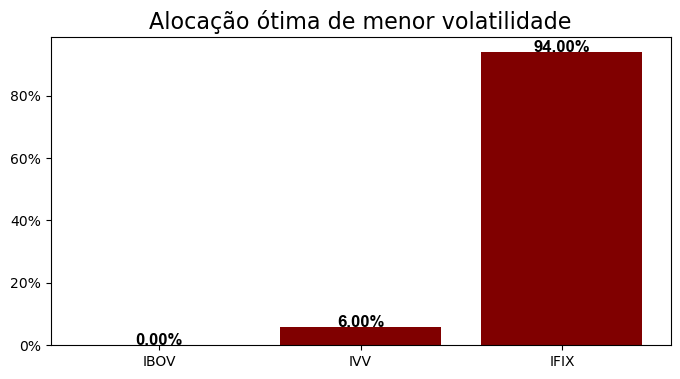

In [157]:
# Gráfico da alocação ótima da carteira de menor risco
x=daily_returns_all_classes_log.columns.to_list()
y=peso_otimo

font={'family': 'arial', 'weight': 'bold', 'size': 12}

# Função para adicionar valor das barras
def addlabels(x, y):
    for i in range(len(x)):
        plt.text(i, y[i], '{:.2%}'.format(y[i]), ha='center', **font)
        

fig, ax = plt.subplots(figsize=(8,4))
plt.bar(x, y, color='maroon')
addlabels(x, y)
plt.title('Alocação ótima de menor volatilidade', fontsize=16)

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

In [158]:
# Carteira de Índice Sharpe máximo

# Estimando a carteira de Sharpe Ratio máximo
def min_func_sharpe(pesos):
    return -(port_ret(pesos)-risk_free_tx)/port_vol(pesos)

# Otimização do Sharpe
otim_sharpe = sco.optimize.minimize(min_func_sharpe, pesos_i, method='SLSQP', bounds=bnds, constraints=restri)

In [159]:
peso_otimo = otim_sharpe['x'].round(2)
ret_otimo = port_ret(otim_sharpe['x'])
vol_otimo = port_vol(otim_sharpe['x'])

print('Rótulos: ', daily_returns_all_classes_log.columns.to_list(), '\n',
     'Pesos da carteira de maior Sharpe: ', peso_otimo, '\n',
     'Retorno da carteira de maior Sharpe: ', '{:.2%}'.format(ret_otimo), '\n',
     'Risco da carteira de maior Sharpe: ', '{:.2%}'.format(vol_otimo))

Rótulos:  ['IBOV', 'IVV', 'IFIX'] 
 Pesos da carteira de maior Sharpe:  [0. 1. 0.] 
 Retorno da carteira de maior Sharpe:  0.07% 
 Risco da carteira de maior Sharpe:  1.51%


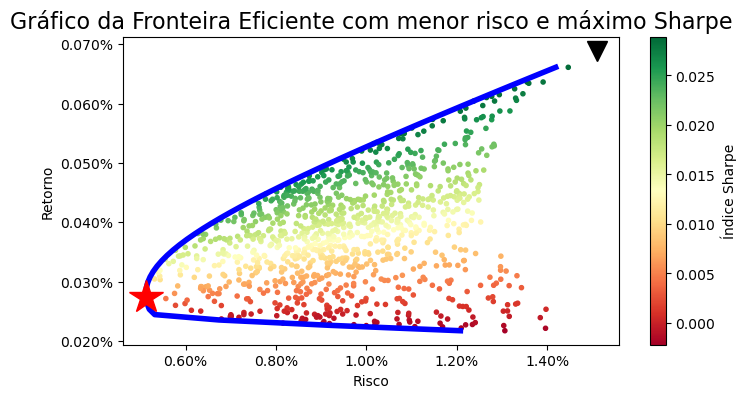

In [160]:
# Gráfico da Fronteira Eficiente com menor risco e máximo Sharpe
plt.figure(figsize=(8,4))
plt.scatter(p_vol, p_ret, c=(p_ret-risk_free_tx)/p_vol, marker='.', cmap='RdYlGn')
plt.plot(tvols, trets, 'b', lw=4)
plt.plot(port_vol(otim_sharpe['x']), port_ret(otim_sharpe['x']), 'kv', markersize=15) # Máximo Sharpe
plt.plot(port_vol(otim_menor_vol['x']), port_ret(otim_menor_vol['x']), 'r*', markersize=25) # Menor Risco
plt.title('Gráfico da Fronteira Eficiente com menor risco e máximo Sharpe', fontsize=16)
plt.xlabel('Risco')
plt.ylabel('Retorno')
plt.colorbar(label='Índice Sharpe')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

In [161]:
# Linha de Alocação de Capital - CAL
# Quanto menor o parâmetro, maior a aversão a risco

a = 8 # Nivel de aversão

eixo_x=[]
eixo_y=[]
utility=[]

for er in np.linspace(risk_free_tx, max(trets),20):
    sd=(er-risk_free_tx)/((port_ret(otim_sharpe['x'])-risk_free_tx)/port_vol(otim_sharpe['x']))
    u = er -0.5*a*(sd**2)
    eixo_x.append(sd)
    eixo_y.append(er)
    utility.append(u)
    
data3={'Utilidade':utility, 'Retorno':eixo_y, 'Risco': eixo_x}
cal=pd.DataFrame(data3)

In [162]:
# Estimar Carteira Ótima completa
wp = (port_ret(otim_sharpe['x'])-risk_free_tx)/(a*port_vol(otim_sharpe['x'])**2)
r_oc = wp*port_ret(otim_sharpe['x'])+(1-wp)*risk_free_tx
v_oc = wp*port_vol(otim_sharpe['x'])
wp

0.24271021165299747

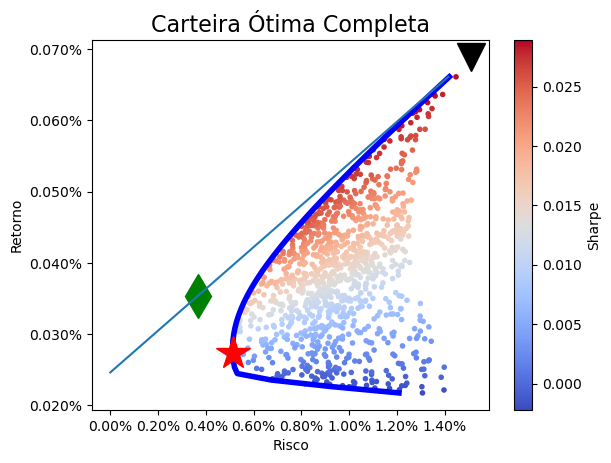

In [163]:
# Gráfico da Carteira Ótima Completa
plt.scatter(p_vol,p_ret, c=(p_ret-risk_free_tx)/p_vol, marker='.', cmap='coolwarm')
plt.plot(tvols,trets,'b',lw=4)
plt.plot(port_vol(otim_sharpe['x']), port_ret(otim_sharpe['x']), 'kv', markersize=20) # Maior Sharpe
plt.plot(port_vol(otim_menor_vol['x']), port_ret(otim_menor_vol['x']), 'r*', markersize=25) # Menor Risco
plt.plot(v_oc, r_oc, 'gd ', markersize=22)
plt.plot(eixo_x, eixo_y)
plt.title('Carteira Ótima Completa', fontsize=16)
plt.xlabel('Risco')
plt.ylabel('Retorno')
plt.colorbar(label='Sharpe')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

In [164]:
# Arranjo de Listas para juntar a carteira com Renda Fixa
p_arr = otim_sharpe['x']
lst_num = p_arr.tolist()
p_s = []
p_tmp = 1-wp

for i in lst_num:
    p_s.append(i*p_tmp) # Contemplar a proporção de ativo livre de risco
    
p_s.append(wp)

rotulo_rf = daily_returns_all_classes_log.columns.to_list()
rotulo_rf.append('Renda Fixa (CDI)')

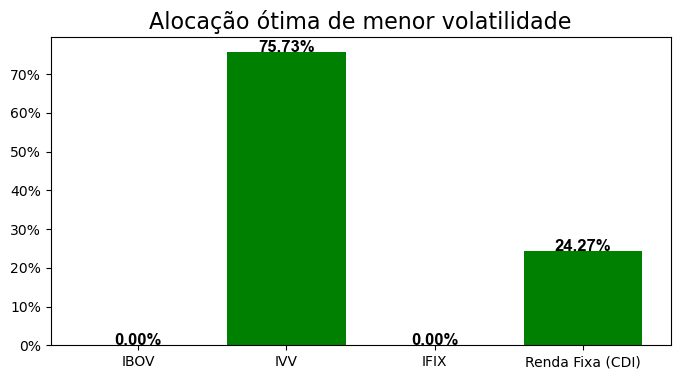

In [165]:
# Gráfico da alocação ótima incluindo Renda Fixa
x=rotulo_rf
y=p_s

font={'family': 'arial', 'weight': 'bold', 'size': 12}

# Função para adicionar valor das barras
def addlabels(x, y):
    for i in range(len(x)):
        plt.text(i, y[i], '{:.2%}'.format(y[i]), ha='center', **font)
        

fig, ax = plt.subplots(figsize=(8,4))
plt.bar(x, y, color='green')
addlabels(x, y)
plt.title('Alocação ótima de menor volatilidade', fontsize=16)

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))